In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from time import time
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import scipy
from sklearn.decomposition import PCA

sns.set(style="whitegrid")

In [2]:
df = pd.read_csv("birch2.txt", sep="\s+", header=None)

# Reduce dataset size to 33% because of limited resources

# Keep only the first 33% of the rows
df = df.iloc[:len(df)//3].reset_index(drop=True)


# Assign column names
df.columns = ['X1', 'X2']

# Preview the first rows
df.head()


,X1,X2
0,58882,63168
1,58959,63322
2,59034,60585
3,59145,61717
4,59164,59757


Dataset shape: (33333, 2)

Summary statistics:
                  X1            X2
count   33333.000000  33333.000000
mean   314231.763958  40363.315483
std    110067.201384  28030.764382
min     47734.000000    479.000000
25%    243883.000000  11174.000000
50%    322262.000000  38261.000000
75%    404324.000000  68954.000000
max    481715.000000  85797.000000


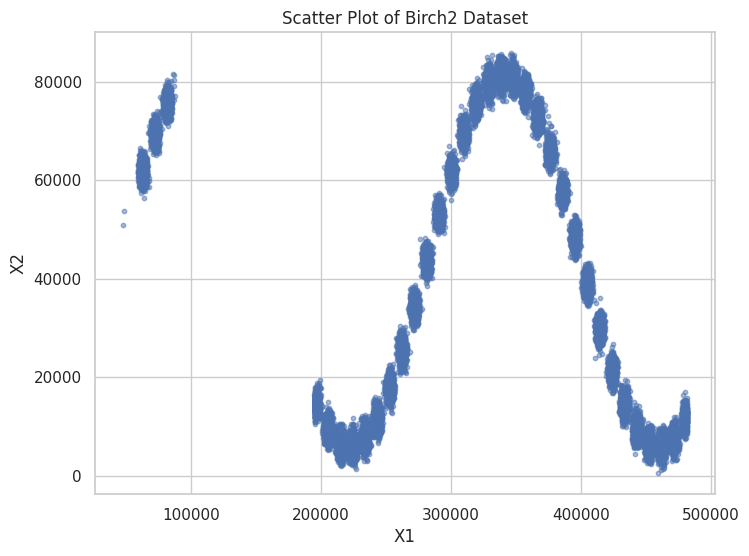

In [3]:
# Basic data exploration and scatter plot

print("Dataset shape:", df.shape)

print("\nSummary statistics:")
print(df.describe())

# 2D scatter plot to visualize point distribution
plt.figure(figsize=(8, 6))
plt.scatter(df['X1'], df['X2'], s=10, alpha=0.5)
plt.title('Scatter Plot of Birch2 Dataset')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [4]:
# Scale the features

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

df_scaled = pd.DataFrame(X_scaled, columns=['X1_scaled', 'X2_scaled'])

df_scaled.head()

,X1_scaled,X2_scaled
0,-2.319979,0.813571
1,-2.319279,0.819065
2,-2.318598,0.721421
3,-2.317590,0.761806
4,-2.317417,0.691882


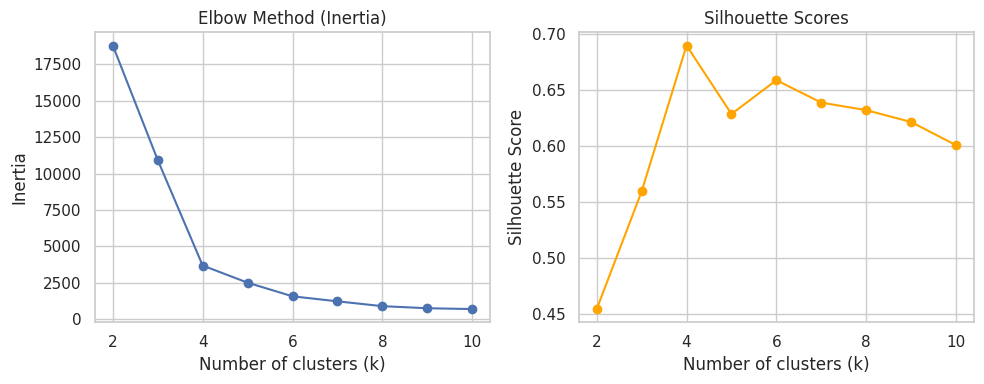

In [5]:
# Elbow and Silhouette using a sample of the dataset

# Sample 17,000 points from the scaled dataset
df_sample = df_scaled.sample(n=17000, random_state=42)
X_sample = df_sample.values

inertia_scores = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_sample)
    inertia_scores.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_sample, labels))

# Plot Inertia (Elbow)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia_scores, marker='o')
plt.title('Elbow Method (Inertia)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [6]:
# Final KMeans clustering with k=4 and result storage

# Initialize KMeans
kmeans_final = KMeans(n_clusters=4, random_state=42)

# Measure execution time
start_time = time()
labels_kmeans = kmeans_final.fit_predict(X_scaled)
execution_time = time() - start_time

# Compute metrics
silhouette_kmeans = silhouette_score(X_scaled, labels_kmeans)
db_index_kmeans = davies_bouldin_score(X_scaled, labels_kmeans)

# Store results in a dictionary
results = {}
results['KMeans_k4'] = {
    'model': kmeans_final,
    'labels': labels_kmeans,
    'n_clusters': 4,
    'silhouette_score': silhouette_kmeans,
    'davies_bouldin_index': db_index_kmeans,
    'execution_time_sec': execution_time
}

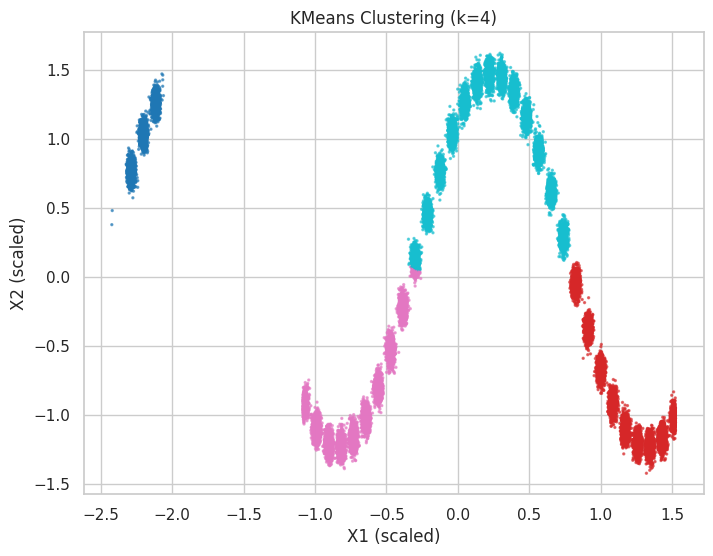

In [14]:
# Scatter plot of KMeans clustering results

plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_kmeans, cmap='tab10', s=2, alpha=0.6)
plt.title('KMeans Clustering (k=4)')
plt.xlabel('X1 (scaled)')
plt.ylabel('X2 (scaled)')
plt.show()

In [7]:
# Print summary of current clustering results
print("Clustering results for KMeans Clustering (k=4):")
print(f"Silhouette Score: {silhouette_kmeans:.4f}")
print(f"Davies-Bouldin Index: {db_index_kmeans:.4f}")
print(f"Execution Time: {execution_time:.2f} seconds")

Clustering results for KMeans Clustering (k=4):
Silhouette Score: 0.6908
Davies-Bouldin Index: 0.4000
Execution Time: 0.03 seconds


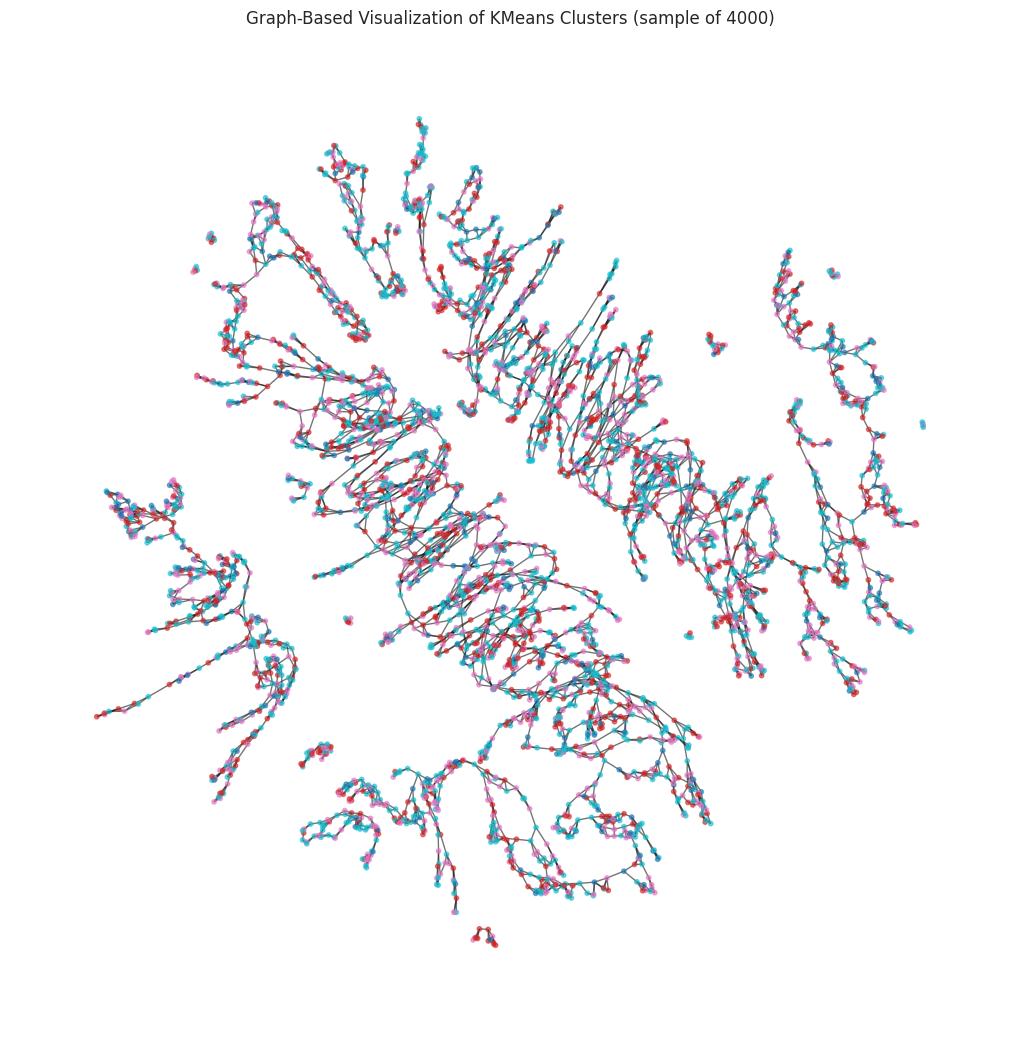

In [16]:
# Sample 4000 points for lighter visualization
sample_size = 4000
sample_indices = np.random.choice(len(X_scaled), size=sample_size, replace=False)
X_sample = X_scaled[sample_indices]
labels_sample = labels_kmeans[sample_indices]
X_pca_sample = PCA(n_components=2).fit_transform(X_sample)

# Find neighbors
n_neighbors = 3
nn = NearestNeighbors(n_neighbors=n_neighbors + 1)
nn.fit(X_sample)
_, indices = nn.kneighbors(X_sample)

# Build graph
G_kmeans = nx.Graph()
for i in range(sample_size):
    G_kmeans.add_node(i, cluster=int(labels_sample[i]))
    for j in indices[i][1:]:
        G_kmeans.add_edge(i, j)

# Positions via PCA layout
positions = {i: (x, y) for i, (x, y) in enumerate(X_pca_sample)}

# Draw
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_kmeans, pos=positions, seed=42, k=0.05, iterations=20)
node_colors = [int(labels_sample[i]) for i in range(sample_size)]
nx.draw(G_kmeans, pos, node_size=10, node_color=node_colors, cmap='tab10', with_labels=False, alpha=0.6)
plt.title("Graph-Based Visualization of KMeans Clusters (sample of 4000)")
plt.show()

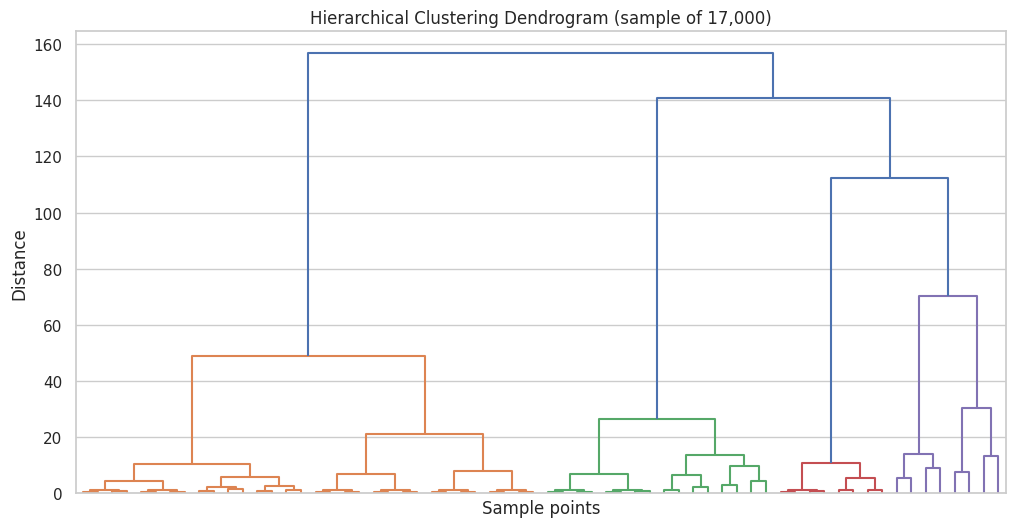

In [9]:
# Hierarchical Clustering (Agglomerative) with dendrogram and result storage

# For dendrogram, we use a sample (too slow on full set)
sample_size = 17000
X_sample = df_scaled.sample(n=sample_size, random_state=42).values

# Compute linkage matrix
linkage_matrix = linkage(X_sample, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=5, no_labels=True)
plt.title('Hierarchical Clustering Dendrogram (sample of 17,000)')
plt.xlabel('Sample points')
plt.ylabel('Distance')
plt.show()

In [10]:
# Apply Agglomerative Clustering with n_clusters=4

# Initialize and fit model
agglo = AgglomerativeClustering(n_clusters=4, linkage='ward')

start_time = time()
labels_agglo = agglo.fit_predict(X_scaled)
execution_time = time() - start_time

# Compute metrics
silhouette_agglo = silhouette_score(X_scaled, labels_agglo)
db_index_agglo = davies_bouldin_score(X_scaled, labels_agglo)

# Store results
results['Agglomerative_k4'] = {
    'model': agglo,
    'labels': labels_agglo,
    'n_clusters': 4,
    'silhouette_score': silhouette_agglo,
    'davies_bouldin_index': db_index_agglo,
    'execution_time_sec': execution_time
}

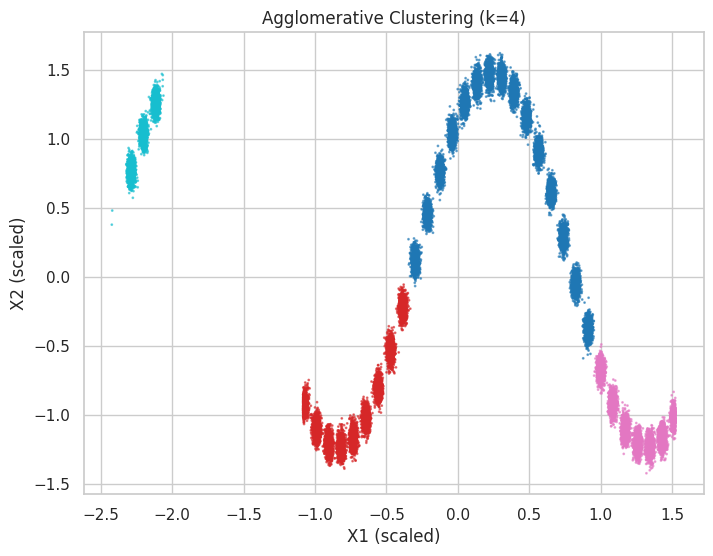

In [11]:
# Plot the result
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_agglo, cmap='tab10', s=1, alpha=0.6)
plt.title('Agglomerative Clustering (k=4)')
plt.xlabel('X1 (scaled)')
plt.ylabel('X2 (scaled)')
plt.show()

In [12]:
# Print summary of current clustering results
print("Clustering results for Agglomerative Clustering (k=4):")
print(f"Silhouette Score: {silhouette_agglo:.4f}")
print(f"Davies-Bouldin Index: {db_index_agglo:.4f}")
print(f"Execution Time: {execution_time:.2f} seconds")

Clustering results for Agglomerative Clustering (k=4):
Silhouette Score: 0.6557
Davies-Bouldin Index: 0.4361
Execution Time: 57.98 seconds


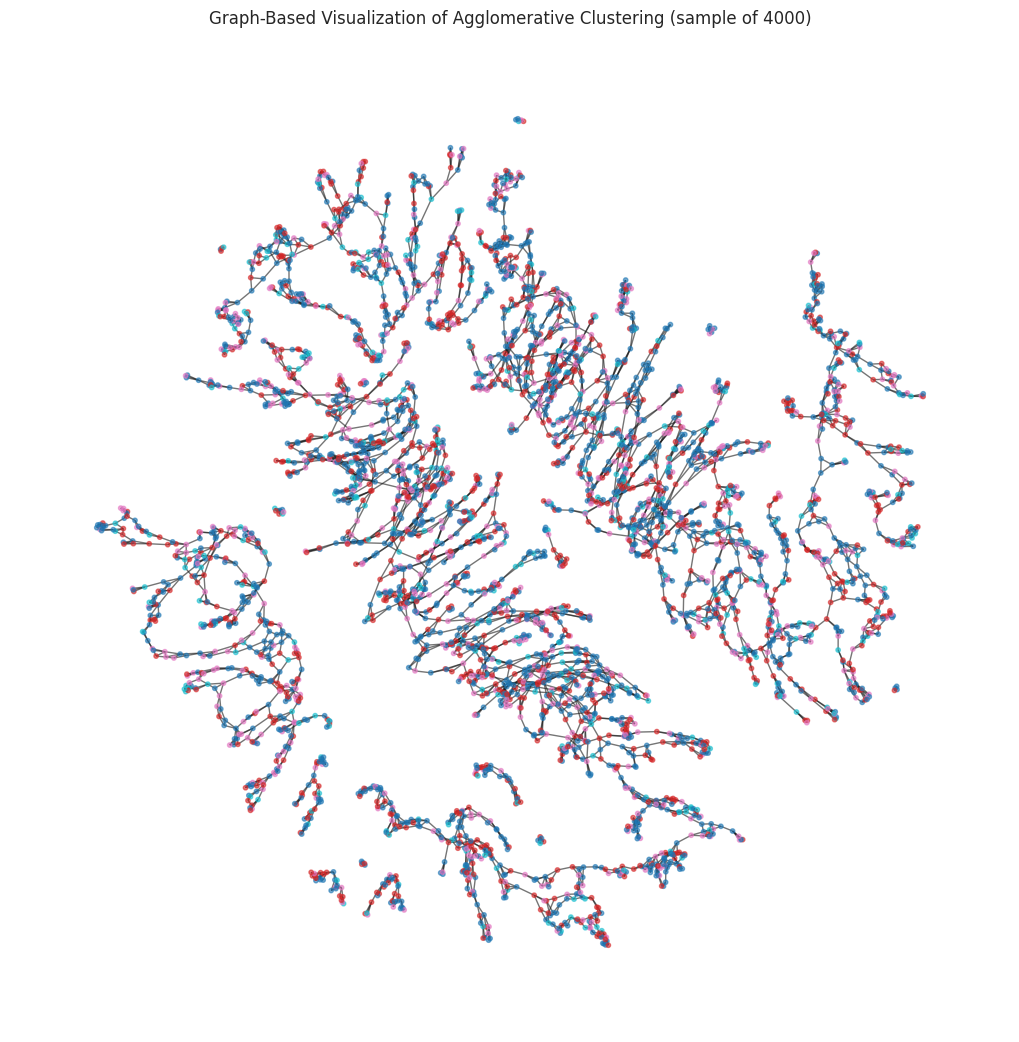

In [13]:
# Graph-based visualization of Agglomerative Clustering (improved)

sample_size = 4000
sample_indices = np.random.choice(len(X_scaled), size=sample_size, replace=False)
X_sample = X_scaled[sample_indices]
labels_sample = [labels_agglo[i] for i in sample_indices]

# PCA for layout
X_pca_sample = PCA(n_components=2).fit_transform(X_sample)
positions = {i: (x, y) for i, (x, y) in enumerate(X_pca_sample)}

# Neighbors & Graph
n_neighbors = 2
nn = NearestNeighbors(n_neighbors=n_neighbors + 1)
nn.fit(X_sample)
_, indices = nn.kneighbors(X_sample)

G_agglo = nx.Graph()
for i in range(sample_size):
    G_agglo.add_node(i, cluster=int(labels_sample[i]))
    for j in indices[i][1:]:
        G_agglo.add_edge(i, j)

# Plot
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_agglo, pos=positions, seed=42, k=0.08, iterations=20)
node_colors = [int(labels_sample[i]) for i in range(sample_size)]
nx.draw(G_agglo, pos, node_size=16, node_color=node_colors, cmap='tab10', with_labels=False, alpha=0.7)

plt.title("Graph-Based Visualization of Agglomerative Clustering (sample of 4000)")
plt.show()


In [17]:
# Apply DBSCAN clustering and store results

# DBSCAN parameters
eps = 0.08
min_samples = 5

# Fit DBSCAN
start_time = time()
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels_dbscan = dbscan.fit_predict(X_scaled)
execution_time = time() - start_time

# Count clusters (excluding noise)
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise = list(labels_dbscan).count(-1)

# Compute metrics (only if there are clusters)
if n_clusters_dbscan > 1:
    silhouette_dbscan = silhouette_score(X_scaled, labels_dbscan)
    db_index_dbscan = davies_bouldin_score(X_scaled, labels_dbscan)
else:
    silhouette_dbscan = None
    db_index_dbscan = None

# Store results
results['DBSCAN'] = {
    'model': dbscan,
    'labels': labels_dbscan,
    'n_clusters': n_clusters_dbscan,
    'n_noise_points': n_noise,
    'eps': eps,
    'min_samples': min_samples,
    'silhouette_score': silhouette_dbscan,
    'davies_bouldin_index': db_index_dbscan,
    'execution_time_sec': execution_time
}

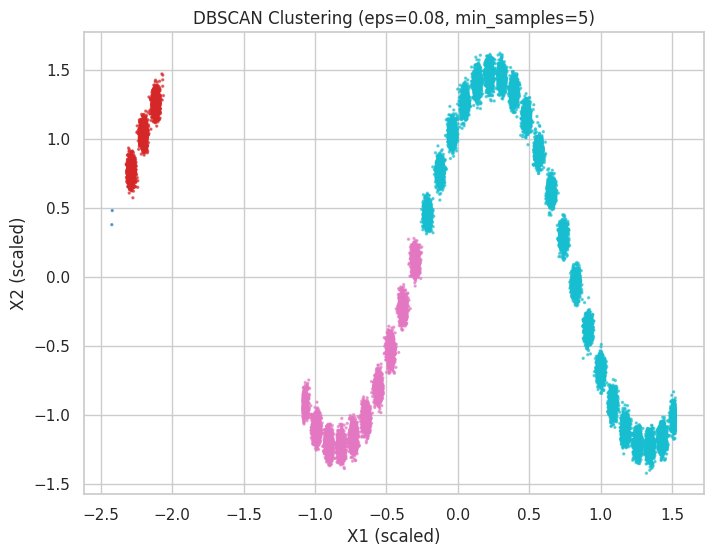

In [18]:
# Scatter plot of DBSCAN result
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_dbscan, cmap='tab10', s=2, alpha=0.6)
plt.title(f'DBSCAN Clustering (eps={eps}, min_samples={min_samples})')
plt.xlabel('X1 (scaled)')
plt.ylabel('X2 (scaled)')
plt.show()

In [19]:
# Print summary
print("Clustering results for DBSCAN:")
print(f"Number of clusters (excluding noise): {n_clusters_dbscan}")
print(f"Noise points: {n_noise}")
print(f"Silhouette Score: {silhouette_dbscan if silhouette_dbscan is not None else 'N/A'}")
print(f"Davies-Bouldin Index: {db_index_dbscan if db_index_dbscan is not None else 'N/A'}")
print(f"Execution Time: {execution_time:.2f} seconds")

Clustering results for DBSCAN:
Number of clusters (excluding noise): 3
Noise points: 2
Silhouette Score: 0.4541652762440701
Davies-Bouldin Index: 0.6480376785205804
Execution Time: 1.87 seconds


In [20]:
# Fine-tune DBSCAN for different eps values

eps_values = [0.05, 0.06, 0.07, 0.08, 0.09, 0.10]
min_samples = 5

dbscan_results = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    if n_clusters > 1:
        silhouette = silhouette_score(X_scaled, labels)
        db_index = davies_bouldin_score(X_scaled, labels)
    else:
        silhouette = None
        db_index = None

    dbscan_results.append({
        'eps': eps,
        'min_samples': min_samples,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'silhouette_score': silhouette,
        'davies_bouldin_index': db_index
    })

# Display results
df_dbscan = pd.DataFrame(dbscan_results)
df_dbscan

,eps,min_samples,n_clusters,n_noise,silhouette_score,davies_bouldin_index
0,0.05,5,8,2,0.477537,0.397037
1,0.06,5,7,2,0.463357,0.402160
2,0.07,5,6,2,0.449611,0.420190
3,0.08,5,3,2,0.454165,0.648038
4,0.09,5,2,2,0.421973,0.500983
5,0.10,5,2,2,0.421973,0.500983


In [21]:
# Fine-tune DBSCAN for different min_samples values with eps=0.05

min_samples_list = [5, 10, 15, 20, 25, 30]
eps = 0.05

dbscan_minsamp_results = []

for min_s in min_samples_list:
    dbscan = DBSCAN(eps=eps, min_samples=min_s)
    labels = dbscan.fit_predict(X_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    if n_clusters > 1:
        silhouette = silhouette_score(X_scaled, labels)
        db_index = davies_bouldin_score(X_scaled, labels)
    else:
        silhouette = None
        db_index = None

    dbscan_minsamp_results.append({
        'eps': eps,
        'min_samples': min_s,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'silhouette_score': silhouette,
        'davies_bouldin_index': db_index
    })

# Display results
pd.DataFrame(dbscan_minsamp_results)


,eps,min_samples,n_clusters,n_noise,silhouette_score,davies_bouldin_index
0,0.05,5,8,2,0.477537,0.397037
1,0.05,10,9,4,0.514260,1.016167
2,0.05,15,9,5,0.516336,1.110503
3,0.05,20,11,6,0.541952,0.990039
4,0.05,25,11,8,0.546859,1.570256
5,0.05,30,11,10,0.548329,2.679217


In [22]:
# Final DBSCAN (tuned) with scatter plot and result storage

# Final parameters
eps = 0.05
min_samples = 20

# Fit DBSCAN
start_time = time()
dbscan_tuned = DBSCAN(eps=eps, min_samples=min_samples)
labels_dbscan_tuned = dbscan_tuned.fit_predict(X_scaled)
execution_time = time() - start_time

# Count clusters and noise
n_clusters = len(set(labels_dbscan_tuned)) - (1 if -1 in labels_dbscan_tuned else 0)
n_noise = list(labels_dbscan_tuned).count(-1)

# Compute metrics
if n_clusters > 1:
    silhouette = silhouette_score(X_scaled, labels_dbscan_tuned)
    db_index = davies_bouldin_score(X_scaled, labels_dbscan_tuned)
else:
    silhouette = None
    db_index = None

# Store results
results['DBSCAN_tuned'] = {
    'model': dbscan_tuned,
    'labels': labels_dbscan_tuned,
    'n_clusters': n_clusters,
    'n_noise_points': n_noise,
    'eps': eps,
    'min_samples': min_samples,
    'silhouette_score': silhouette,
    'davies_bouldin_index': db_index,
    'execution_time_sec': execution_time
}

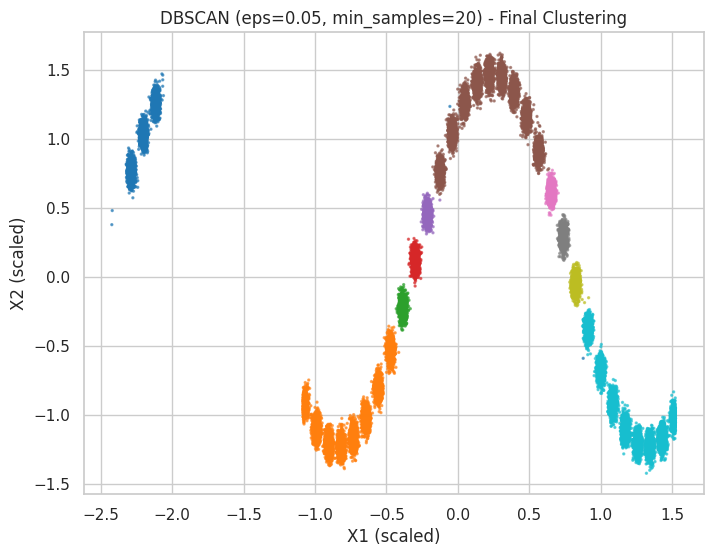

In [23]:
# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_dbscan_tuned, cmap='tab10', s=2, alpha=0.6)
plt.title(f'DBSCAN (eps={eps}, min_samples={min_samples}) - Final Clustering')
plt.xlabel('X1 (scaled)')
plt.ylabel('X2 (scaled)')
plt.show()

In [24]:
# Print summary
print("Final DBSCAN (tuned) Results:")
print(f"Number of clusters (excluding noise): {n_clusters}")
print(f"Noise points: {n_noise}")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Execution Time: {execution_time:.2f} seconds")

Final DBSCAN (tuned) Results:
Number of clusters (excluding noise): 11
Noise points: 6
Silhouette Score: 0.5420
Davies-Bouldin Index: 0.9900
Execution Time: 1.12 seconds


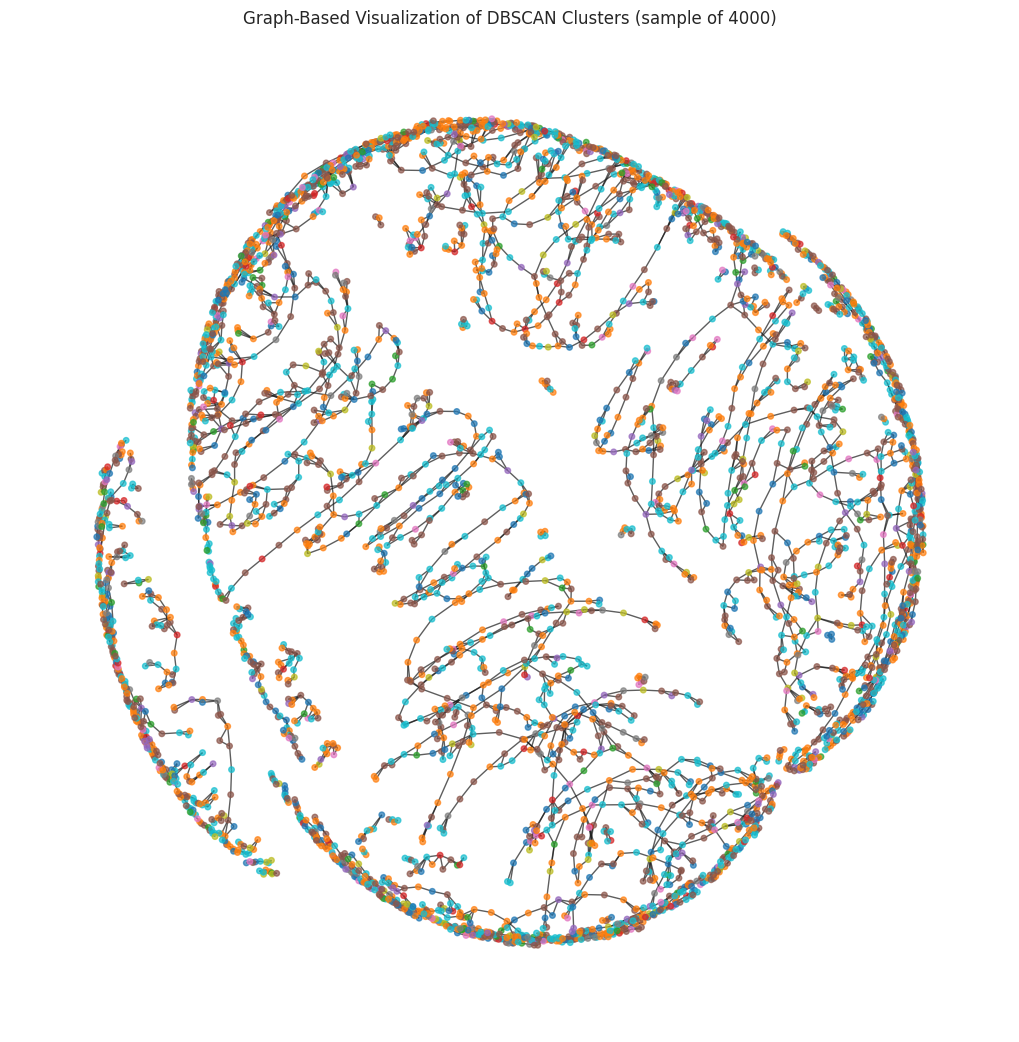

In [26]:
# Graph-based visualization of DBSCAN (sample of 4000)

sample_size = 4000
sample_indices = np.random.choice(len(X_scaled), size=sample_size, replace=False)
X_sample = X_scaled[sample_indices]
labels_sample = [labels_dbscan_tuned[i] for i in sample_indices]

# PCA for layout
X_pca_sample = PCA(n_components=2).fit_transform(X_sample)
positions = {i: (x, y) for i, (x, y) in enumerate(X_pca_sample)}

# Nearest neighbors
n_neighbors = 2
nn = NearestNeighbors(n_neighbors=n_neighbors + 1)
nn.fit(X_sample)
_, indices = nn.kneighbors(X_sample)

# Build graph
G_dbscan = nx.Graph()
for i in range(sample_size):
    G_dbscan.add_node(i, cluster=int(labels_sample[i]))
    for j in indices[i][1:]:  # Skip self
        G_dbscan.add_edge(i, j)

# Plot graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_dbscan, pos=positions, seed=42, k=0.08, iterations=20)
node_colors = [int(labels_sample[i]) for i in range(sample_size)]
nx.draw(G_dbscan, pos, node_size=16, node_color=node_colors, cmap='tab10', with_labels=False, alpha=0.7)

plt.title("Graph-Based Visualization of DBSCAN Clusters (sample of 4000)")
plt.show()
